In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import torchvision.models as models

from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import numpy as np
import os
#from google.colab import drive
from torchsummary import summary

# import time 

/net/dali/home/mscbio/fea54/.conda/envs/10701-env-hw4/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/net/dali/home/mscbio/fea54/.conda/envs/10701-env-hw4/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
#!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz
#!tar -xvzf /content/drive/MyDrive/imagenette2.tgz -C /content/drive/MyDrive/

#drive.mount('/content/drive')

In [3]:
path = "~/CPCB/imagenette2"

In [4]:
# Create common transformations for both training and validation
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(*imagenet_stats)
])

# Apply transformations directly to datasets
train_dataset = ImageFolder(root=os.path.join(path, 'train/'), transform=common_transforms)
val_dataset = ImageFolder(root=os.path.join(path, 'val/'), transform=common_transforms)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [5]:
model_names = dir(models)
#print(model_names)

In [6]:
# Load pre-trained AlexNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.alexnet(weights='AlexNet_Weights.DEFAULT')

#Change the number of output classes
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
# Training and evaluation functions
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradients for faster inference
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device

            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predictions

            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy

### AlexNet With No Replacement

In [7]:
# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

#Unfreeze the last layer
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [8]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss[epoch] = train(model, train_loader, criterion, optimizer, device)
    val_accuracy[epoch] = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}")

100%|██████████| 62/62 [00:18<00:00,  3.32it/s]


Epoch 1, Train Loss: 0.5611, Val Accuracy: 0.8792


100%|██████████| 62/62 [00:10<00:00,  5.85it/s]


Epoch 2, Train Loss: 0.3605, Val Accuracy: 0.8899


100%|██████████| 62/62 [00:09<00:00,  6.31it/s]


Epoch 3, Train Loss: 0.3051, Val Accuracy: 0.8950


100%|██████████| 62/62 [00:09<00:00,  6.27it/s]


Epoch 4, Train Loss: 0.2846, Val Accuracy: 0.8955


100%|██████████| 62/62 [00:09<00:00,  6.33it/s]


Epoch 5, Train Loss: 0.2495, Val Accuracy: 0.8894


100%|██████████| 62/62 [00:09<00:00,  6.33it/s]


Epoch 6, Train Loss: 0.2381, Val Accuracy: 0.8848


100%|██████████| 62/62 [00:09<00:00,  6.28it/s]


Epoch 7, Train Loss: 0.2400, Val Accuracy: 0.8930


100%|██████████| 62/62 [00:09<00:00,  6.25it/s]


Epoch 8, Train Loss: 0.2091, Val Accuracy: 0.9001


100%|██████████| 62/62 [00:09<00:00,  6.31it/s]


Epoch 9, Train Loss: 0.2086, Val Accuracy: 0.8925


100%|██████████| 62/62 [00:09<00:00,  6.25it/s]

Epoch 10, Train Loss: 0.2002, Val Accuracy: 0.8935


In [9]:
print(train_loss)
print(val_accuracy)

[0.56110342 0.36046899 0.30514185 0.28456746 0.24948658 0.23805106
 0.24004159 0.20912269 0.2086487  0.20023224]
[0.87923567 0.88993631 0.89503185 0.8955414  0.88942675 0.88484076
 0.89299363 0.90012739 0.89248408 0.89350318]


## AlexNet With Last Layer Replaced

In [9]:
model_lastreplaced = model
model_lastreplaced.to(device)

# Freeze all parameters first
for param in model_replaced.parameters():
    param.requires_grad = False

new_layer = nn.Sequential(
     nn.Linear(13, 13)
)

# Replace the 10th layer with the new Linear layer
model_lastreplaced.features[10] = new_layer

for param in model_lastreplaced.classifier[6].parameters(): # replaced 
    param.requires_grad = True

for param in model_lastreplaced.features[10].parameters():
    param.requires_grad = True


optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_lastreplaced.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
model_replaced.to(device)
model_replaced

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Sequential(
      (0): Linear(in_features=13, out_features=13, bias=True)
    )
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, 

In [11]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_replaced.parameters(), lr=0.001)
train_loss_replaced = np.zeros(num_epochs)
val_accuracy_replaced = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_replaced[epoch] = train(model_replaced, train_loader, criterion, optimizer, device)
    val_accuracy_replaced[epoch] = evaluate(model_replaced, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_replaced[epoch]:.4f}, Val Accuracy: {val_accuracy_replaced[epoch]:.4f}")

100%|██████████| 62/62 [00:20<00:00,  3.04it/s]


Epoch 1, Train Loss: 1.3555, Val Accuracy: 0.7307


100%|██████████| 62/62 [00:10<00:00,  6.02it/s]


Epoch 2, Train Loss: 0.9212, Val Accuracy: 0.7949


100%|██████████| 62/62 [00:09<00:00,  6.27it/s]


Epoch 3, Train Loss: 0.8063, Val Accuracy: 0.8163


100%|██████████| 62/62 [00:09<00:00,  6.27it/s]


Epoch 4, Train Loss: 0.7408, Val Accuracy: 0.8161


100%|██████████| 62/62 [00:09<00:00,  6.32it/s]


Epoch 5, Train Loss: 0.7091, Val Accuracy: 0.8028


100%|██████████| 62/62 [00:09<00:00,  6.33it/s]


Epoch 6, Train Loss: 0.6951, Val Accuracy: 0.8135


100%|██████████| 62/62 [00:09<00:00,  6.32it/s]


Epoch 7, Train Loss: 0.6715, Val Accuracy: 0.8122


100%|██████████| 62/62 [00:09<00:00,  6.37it/s]


Epoch 8, Train Loss: 0.6395, Val Accuracy: 0.8099


100%|██████████| 62/62 [00:09<00:00,  6.36it/s]


Epoch 9, Train Loss: 0.6418, Val Accuracy: 0.8143


100%|██████████| 62/62 [00:09<00:00,  6.33it/s]

Epoch 10, Train Loss: 0.6245, Val Accuracy: 0.8275


In [12]:
print(train_loss_replaced)
print(val_accuracy_replaced)

[1.35554119 0.92124472 0.80633774 0.74075248 0.7090601  0.69513154
 0.67152603 0.63948786 0.64175714 0.62445649]
[0.73070064 0.79490446 0.81630573 0.81605096 0.80280255 0.81350318
 0.8122293  0.80993631 0.81426752 0.82751592]


In [86]:
train_loss_replaced = [1.35554119, 0.92124472, 0.80633774, 0.74075248, 0.7090601, 
                       0.69513154, 0.67152603, 0.63948786, 0.64175714, 0.62445649]

val_accuracy_replaced = [0.73070064, 0.79490446, 0.81630573, 0.81605096, 0.80280255, 
                         0.81350318, 0.8122293, 0.80993631, 0.81426752, 0.82751592]


In [ ]:
plt.plot(epoch, train_loss_changed, label="Training Loss with Layer Removed")
plt.plot(epoch, train_loss, label="Baseline Training Loss")
plt.title("Training Loss of ResNet18 on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
#val_accuracies = [0.97503185 0.96968153 0.97299363 0.97019108 0.9722293  0.97375796 0.97171975 0.96968153 0.97248408 0.97146497]

epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracy, label="Validation Accuracy with Layer Removed")
plt.plot(epoch, val_accuracies, label="Baseline Validation Accuracy")
plt.title("Validation Accuracy of AlexNet on Imagenette")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
print(val_accuracy)

## Model with First Layer Replaced

In [155]:
# Load pre-trained AlexNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.alexnet(weights='AlexNet_Weights.DEFAULT')

#Change the number of output classes
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [156]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [157]:
model_firstreplaced = model

# Freeze all parameters first
for param in model_firstreplaced.parameters():
    param.requires_grad = False

#Unfreeze the last layer
for param in model_firstreplaced.classifier[6].parameters():
    param.requires_grad = True

# torch.cuda.empty_cache()

In [158]:
new_firstlayer = nn.Linear(27, 27)
#new_firstlayer = nn.Linear(model_firstreplaced.features[0].out_channels, model_firstreplaced.features[6].in_channels)

# Replace the 1st layer with the new Linear layer
model_firstreplaced.features[3] = new_firstlayer
model_firstreplaced.features[6] = nn.Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_firstreplaced.features[8] = nn.Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

for param in model_firstreplaced.classifier[6].parameters(): # replaced 
    param.requires_grad = True

for param in model_firstreplaced.features[3].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_firstreplaced.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [159]:
model_firstreplaced.to(device)
model_firstreplaced

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Linear(in_features=27, out_features=27, bias=True)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpl

In [160]:
#execution_time = time_cell()
    
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_firstreplaced.parameters(), lr=0.001)
train_loss_firstreplaced = np.zeros(num_epochs)
val_accuracy_firstreplaced = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_firstreplaced[epoch] = train(model_firstreplaced, train_loader, criterion, optimizer, device)
    val_accuracy_firstreplaced[epoch] = evaluate(model_firstreplaced, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_firstreplaced[epoch]:.4f}, Val Accuracy: {val_accuracy_firstreplaced[epoch]:.4f}")
    

#print(f"The cell took {execution_time} seconds to run.")

100%|██████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 1, Train Loss: 1.9252, Val Accuracy: 0.4375


100%|██████████| 62/62 [00:13<00:00,  4.48it/s]


Epoch 2, Train Loss: 1.4273, Val Accuracy: 0.5437


100%|██████████| 62/62 [00:13<00:00,  4.51it/s]


Epoch 3, Train Loss: 1.1891, Val Accuracy: 0.6525


100%|██████████| 62/62 [00:13<00:00,  4.52it/s]


Epoch 4, Train Loss: 1.0115, Val Accuracy: 0.6869


100%|██████████| 62/62 [00:13<00:00,  4.59it/s]


Epoch 5, Train Loss: 0.9018, Val Accuracy: 0.7149


100%|██████████| 62/62 [00:13<00:00,  4.56it/s]


Epoch 6, Train Loss: 0.7867, Val Accuracy: 0.7192


100%|██████████| 62/62 [00:13<00:00,  4.53it/s]


Epoch 7, Train Loss: 0.7303, Val Accuracy: 0.7468


100%|██████████| 62/62 [00:13<00:00,  4.59it/s]


Epoch 8, Train Loss: 0.6705, Val Accuracy: 0.7399


100%|██████████| 62/62 [00:13<00:00,  4.61it/s]


Epoch 9, Train Loss: 0.6159, Val Accuracy: 0.7529


100%|██████████| 62/62 [00:13<00:00,  4.59it/s]

Epoch 10, Train Loss: 0.5660, Val Accuracy: 0.7674


In [59]:
print(train_loss_firstreplaced)
print(val_accuracy_firstreplaced)

train_loss = [0.56110342, 0.36046899, 0.30514185, 0.28456746, 0.24948658, 0.23805106, 0.24004159, 0.20912269, 0.2086487,  0.20023224]
val_accuracy = [0.87923567, 0.88993631, 0.89503185, 0.8955414,  0.88942675, 0.88484076, 0.89299363, 0.90012739, 0.89248408, 0.89350318]



[1.17717046, 1.00994323, 0.89126945, 0.83326771, 0.7692424, 0.73595149, 0.68732599, 0.64416528, 0.62884825, 0.58739365]
[0.65121019, 0.65783439, 0.71617834, 0.71745223, 0.71949045, 0.74369427, 0.74955414, 0.74267516, 0.75821656, 0.74394904]


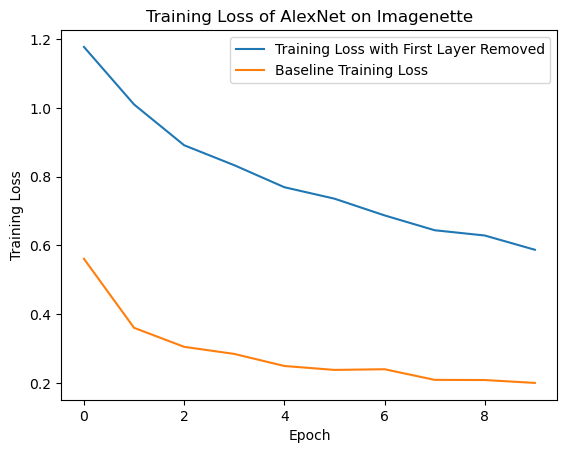

In [60]:
train_loss_firstreplaced = [1.17717046, 1.00994323, 0.89126945, 0.83326771, 0.7692424,  0.73595149,
 0.68732599, 0.64416528, 0.62884825, 0.58739365]
val_accuracy_firstreplaced = [0.65121019, 0.65783439, 0.71617834, 0.71745223, 0.71949045, 0.74369427,
 0.74955414, 0.74267516, 0.75821656, 0.74394904]

plt.plot(train_loss_firstreplaced, label="Training Loss with First Layer Removed")
plt.plot(train_loss, label="Baseline Training Loss")
plt.title("Training Loss of AlexNet on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

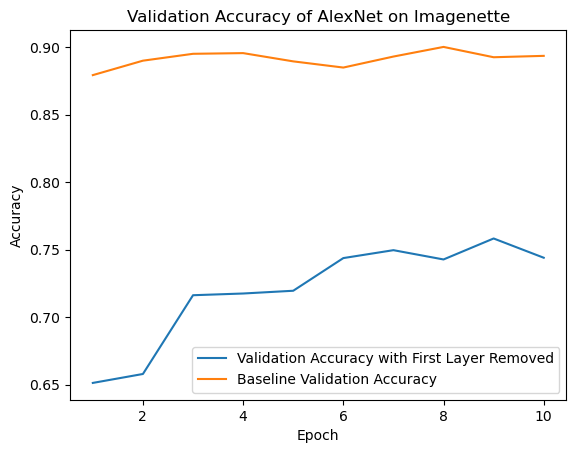

In [163]:
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracy_firstreplaced, label="Validation Accuracy with First Layer Removed")
plt.plot(epoch, val_accuracy, label="Baseline Validation Accuracy")
plt.title("Validation Accuracy of AlexNet on Imagenette")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
# print(val_accuracy)

## Model with Middle Layer Replaced

In [16]:
torch.cuda.empty_cache()

# Load pre-trained AlexNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.alexnet(weights='AlexNet_Weights.DEFAULT')

#Change the number of output classes
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [18]:
model_middlereplaced = model
# model_middlereplaced.to(device)

# Freeze all parameters first
for param in model_middlereplaced.parameters():
    param.requires_grad = False


In [19]:
new_middlelayer = nn.Linear(13,13)

# Replace the middle layer with the new Linear layer
model_middlereplaced.features[6] = new_middlelayer
model_middlereplaced.features[8] = nn.Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

for param in model_middlereplaced.classifier[6].parameters():
    param.requires_grad = True

for param in model_middlereplaced.features[6].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_middlereplaced.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [20]:
model_middlereplaced

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Linear(in_features=13, out_features=13, bias=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpl

In [169]:
model_middlereplaced.to(device)
summary(model_middlereplaced, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Linear-7          [-1, 192, 13, 13]             182
              ReLU-8          [-1, 192, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         442,624
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [170]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_middlereplaced.parameters(), lr=0.001)
train_loss_middlereplaced = np.zeros(num_epochs)
val_accuracy_middlereplaced = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_middlereplaced[epoch] = train(model_middlereplaced, train_loader, criterion, optimizer, device)
    val_accuracy_middlereplaced[epoch] = evaluate(model_middlereplaced, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_middlereplaced[epoch]:.4f}, Val Accuracy: {val_accuracy_middlereplaced[epoch]:.4f}")

100%|██████████| 62/62 [00:13<00:00,  4.59it/s]


Epoch 1, Train Loss: 1.8353, Val Accuracy: 0.5001


100%|██████████| 62/62 [00:13<00:00,  4.57it/s]


Epoch 2, Train Loss: 1.2093, Val Accuracy: 0.7070


100%|██████████| 62/62 [00:13<00:00,  4.58it/s]


Epoch 3, Train Loss: 0.9144, Val Accuracy: 0.7157


100%|██████████| 62/62 [00:13<00:00,  4.59it/s]


Epoch 4, Train Loss: 0.7725, Val Accuracy: 0.7801


100%|██████████| 62/62 [00:13<00:00,  4.60it/s]


Epoch 5, Train Loss: 0.6929, Val Accuracy: 0.7957


100%|██████████| 62/62 [00:13<00:00,  4.59it/s]


Epoch 6, Train Loss: 0.6035, Val Accuracy: 0.8056


100%|██████████| 62/62 [00:13<00:00,  4.62it/s]


Epoch 7, Train Loss: 0.5565, Val Accuracy: 0.8122


100%|██████████| 62/62 [00:13<00:00,  4.63it/s]


Epoch 8, Train Loss: 0.5002, Val Accuracy: 0.8130


100%|██████████| 62/62 [00:13<00:00,  4.61it/s]


Epoch 9, Train Loss: 0.4551, Val Accuracy: 0.8153


100%|██████████| 62/62 [00:13<00:00,  4.54it/s]

Epoch 10, Train Loss: 0.4157, Val Accuracy: 0.8234


In [81]:
print(train_loss_middlereplaced)
print(val_accuracy_middlereplaced)

NameError: name 'train_loss_middlereplaced' is not defined

In [82]:
train_loss_middlereplaced = [1.83530433, 1.20928194, 0.91440231, 0.77249772, 0.69291078, 
                             0.60347796, 0.55650919, 0.50021483, 0.45505989, 0.4157415]

val_accuracy_middlereplaced = [0.50012739, 0.70700637, 0.71566879, 0.78012739, 0.79566879, 
                               0.8056051, 0.8122293, 0.81299363, 0.81528662, 0.82343949]

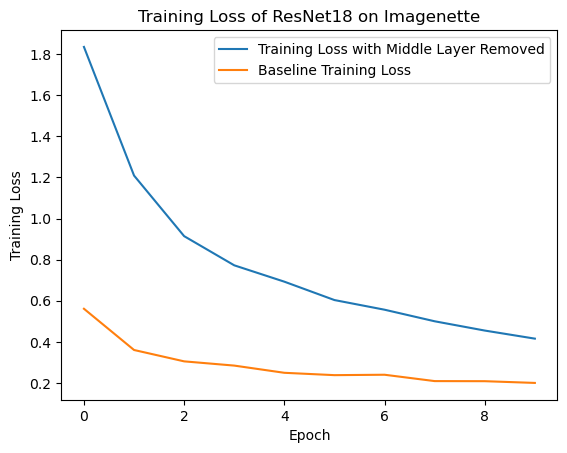

In [83]:
plt.plot(train_loss_middlereplaced, label="Training Loss with Middle Layer Removed")
plt.plot(train_loss, label="Baseline Training Loss")
plt.title("Training Loss of ResNet18 on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

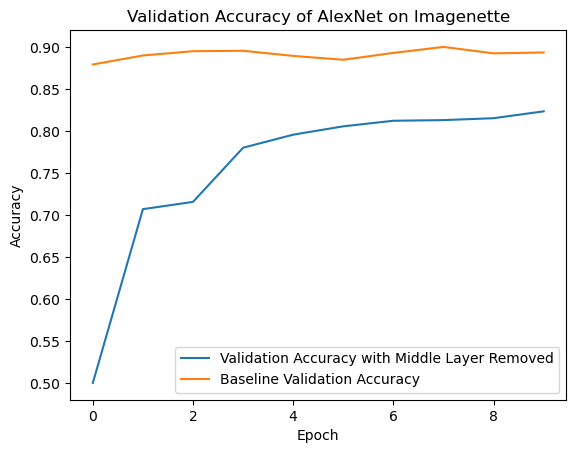

[0.87923567, 0.88993631, 0.89503185, 0.8955414, 0.88942675, 0.88484076, 0.89299363, 0.90012739, 0.89248408, 0.89350318]


In [173]:
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(val_accuracy_middlereplaced, label="Validation Accuracy with Middle Layer Removed")
plt.plot(val_accuracy, label="Baseline Validation Accuracy")
plt.title("Validation Accuracy of AlexNet on Imagenette")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
print(val_accuracy)

# Combined AlexNets

## First and Middle

In [174]:
torch.cuda.empty_cache()

# Load pre-trained AlexNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.alexnet(weights='AlexNet_Weights.DEFAULT')

#Change the number of output classes
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [175]:
model_firstmiddle_replaced = model
# model_middlereplaced.to(device)

# Freeze all parameters first
for param in model_firstmiddle_replaced.parameters():
    param.requires_grad = False

In [176]:
model_firstmiddle_replaced

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [177]:
# Replace the 1st layer with the new Linear layer
model_firstmiddle_replaced.features[3] = new_firstlayer
model_firstmiddle_replaced.features[6] = new_middlelayer
model_firstmiddle_replaced.features[8] = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

for param in model_firstmiddle_replaced.classifier[6].parameters(): # replaced 
    param.requires_grad = True

for param in model_firstmiddle_replaced.features[3].parameters():
    param.requires_grad = True
    
for param in model_firstmiddle_replaced.features[6].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_firstmiddle_replaced.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [178]:
model_firstmiddle_replaced.to(device)
summary(model_firstmiddle_replaced, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Linear-4           [-1, 64, 27, 27]             756
              ReLU-5           [-1, 64, 27, 27]               0
         MaxPool2d-6           [-1, 64, 13, 13]               0
            Linear-7           [-1, 64, 13, 13]             182
              ReLU-8           [-1, 64, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         147,712
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [179]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_firstmiddle_replaced.parameters(), lr=0.001)
train_loss_firstmiddlereplaced = np.zeros(num_epochs)
val_accuracy_firstmiddlereplaced = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_firstmiddlereplaced[epoch] = train(model_firstmiddle_replaced, train_loader, criterion, optimizer, device)
    val_accuracy_firstmiddlereplaced[epoch] = evaluate(model_firstmiddle_replaced, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_firstmiddlereplaced[epoch]:.4f}, Val Accuracy: {val_accuracy_firstmiddlereplaced[epoch]:.4f}")

100%|██████████| 62/62 [00:13<00:00,  4.65it/s]


Epoch 1, Train Loss: 1.4698, Val Accuracy: 0.6354


100%|██████████| 62/62 [00:13<00:00,  4.63it/s]


Epoch 2, Train Loss: 1.0178, Val Accuracy: 0.6887


100%|██████████| 62/62 [00:13<00:00,  4.66it/s]


Epoch 3, Train Loss: 0.8690, Val Accuracy: 0.7006


100%|██████████| 62/62 [00:13<00:00,  4.71it/s]


Epoch 4, Train Loss: 0.7813, Val Accuracy: 0.7292


100%|██████████| 62/62 [00:13<00:00,  4.69it/s]


Epoch 5, Train Loss: 0.7175, Val Accuracy: 0.7220


100%|██████████| 62/62 [00:13<00:00,  4.68it/s]


Epoch 6, Train Loss: 0.6712, Val Accuracy: 0.7427


100%|██████████| 62/62 [00:13<00:00,  4.67it/s]


Epoch 7, Train Loss: 0.6052, Val Accuracy: 0.7488


100%|██████████| 62/62 [00:13<00:00,  4.64it/s]


Epoch 8, Train Loss: 0.5781, Val Accuracy: 0.7465


100%|██████████| 62/62 [00:13<00:00,  4.66it/s]


Epoch 9, Train Loss: 0.5370, Val Accuracy: 0.7595


100%|██████████| 62/62 [00:13<00:00,  4.68it/s]

Epoch 10, Train Loss: 0.4999, Val Accuracy: 0.7557


In [180]:
print(train_loss_firstmiddlereplaced)
print(val_accuracy_firstmiddlereplaced)

[1.46977909 1.01775082 0.86903141 0.78132941 0.71746236 0.67115778
 0.60523295 0.57806235 0.53696678 0.49991345]
[0.63541401 0.68866242 0.70063694 0.72917197 0.72203822 0.74267516
 0.74878981 0.74649682 0.75949045 0.75566879]


In [79]:
train_loss_firstmiddlereplaced = [1.46977909, 1.01775082, 0.86903141, 0.78132941, 0.71746236, 
                                  0.67115778, 0.60523295, 0.57806235, 0.53696678, 0.49991345]

val_accuracy_firstmiddlereplaced = [0.63541401, 0.68866242, 0.70063694, 0.72917197, 0.72203822, 
                                    0.74267516, 0.74878981, 0.74649682, 0.75949045, 0.75566879]


## First and Last

In [181]:
torch.cuda.empty_cache()

# Load pre-trained AlexNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.alexnet(weights='AlexNet_Weights.DEFAULT')

#Change the number of output classes
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [182]:
model_firstlast_replaced = model
model_firstlast_replaced.to(device)

# Freeze all parameters first
for param in model_firstlast_replaced.parameters():
    param.requires_grad = False

In [183]:
# Replace the 1st layer with the new Linear layer
new_lastlayer = nn.Linear(13, 13)
model_firstlast_replaced.features[3] = new_firstlayer
model_firstlast_replaced.features[6] = nn.Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_firstlast_replaced.features[8] = nn.Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_firstlast_replaced.features[10] = new_lastlayer

for param in model_firstlast_replaced.classifier[6].parameters(): # replaced 
    param.requires_grad = True

for param in model_firstlast_replaced.features[3].parameters():
    param.requires_grad = True
    
for param in model_firstlast_replaced.features[10].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_firstlast_replaced.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [184]:
model_firstlast_replaced

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Linear(in_features=27, out_features=27, bias=True)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Linear(in_features=13, out_features=13, bias=True)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3)

In [185]:
model_firstlast_replaced.to(device)
summary(model_firstlast_replaced, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Linear-4           [-1, 64, 27, 27]             756
              ReLU-5           [-1, 64, 27, 27]               0
         MaxPool2d-6           [-1, 64, 13, 13]               0
            Conv2d-7          [-1, 192, 13, 13]         110,784
              ReLU-8          [-1, 192, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         442,624
             ReLU-10          [-1, 256, 13, 13]               0
           Linear-11          [-1, 256, 13, 13]             182
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [186]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_firstlast_replaced.parameters(), lr=0.001)
train_loss_firstlastreplaced = np.zeros(num_epochs)
val_accuracy_firstlastreplaced = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_firstlastreplaced[epoch] = train(model_firstlast_replaced, train_loader, criterion, optimizer, device)
    val_accuracy_firstlastreplaced[epoch] = evaluate(model_firstlast_replaced, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_firstlastreplaced[epoch]:.4f}, Val Accuracy: {val_accuracy_firstlastreplaced[epoch]:.4f}")

100%|██████████| 62/62 [00:13<00:00,  4.67it/s]


Epoch 1, Train Loss: 1.6697, Val Accuracy: 0.5969


100%|██████████| 62/62 [00:13<00:00,  4.63it/s]


Epoch 2, Train Loss: 1.0906, Val Accuracy: 0.6777


100%|██████████| 62/62 [00:13<00:00,  4.64it/s]


Epoch 3, Train Loss: 0.9004, Val Accuracy: 0.7039


100%|██████████| 62/62 [00:13<00:00,  4.60it/s]


Epoch 4, Train Loss: 0.7912, Val Accuracy: 0.7304


100%|██████████| 62/62 [00:13<00:00,  4.64it/s]


Epoch 5, Train Loss: 0.6893, Val Accuracy: 0.7597


100%|██████████| 62/62 [00:13<00:00,  4.64it/s]


Epoch 6, Train Loss: 0.6292, Val Accuracy: 0.7610


100%|██████████| 62/62 [00:12<00:00,  4.78it/s]


Epoch 7, Train Loss: 0.5583, Val Accuracy: 0.7554


100%|██████████| 62/62 [00:12<00:00,  4.88it/s]


Epoch 8, Train Loss: 0.5162, Val Accuracy: 0.7659


100%|██████████| 62/62 [00:12<00:00,  4.85it/s]


Epoch 9, Train Loss: 0.4534, Val Accuracy: 0.7804


100%|██████████| 62/62 [00:12<00:00,  4.84it/s]

Epoch 10, Train Loss: 0.4021, Val Accuracy: 0.7796


In [187]:
print(train_loss_firstlastreplaced)
print(val_accuracy_firstlastreplaced)

[1.66969077 1.09061797 0.90042357 0.79119048 0.68934164 0.62921243
 0.55828959 0.51617261 0.45341297 0.40210193]
[0.59694268 0.67770701 0.70394904 0.73044586 0.75974522 0.76101911
 0.75541401 0.76585987 0.78038217 0.77961783]


In [78]:
train_loss_firstlastreplaced = [1.66969077, 1.09061797, 0.90042357, 0.79119048, 0.68934164, 
                               0.62921243, 0.55828959, 0.51617261, 0.45341297, 0.40210193]

val_accuracy_firstlastreplaced = [0.59694268, 0.67770701, 0.70394904, 0.73044586, 0.75974522, 
                                  0.76101911, 0.75541401, 0.76585987, 0.78038217, 0.77961783]


## Middle and Last

In [26]:
torch.cuda.empty_cache()

# Load pre-trained AlexNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.alexnet(weights='AlexNet_Weights.DEFAULT')

#Change the number of output classes
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
model_middlelast_replaced = model
model_middlelast_replaced.to(device)

# Freeze all parameters first
for param in model_middlelast_replaced.parameters():
    param.requires_grad = False

In [37]:
# Replace the 1st layer with the new Linear layer
new_lastlayer = nn.Linear(13, 13)
# model_middlelast_replaced.features[3] = new_firstlayer
model_middlelast_replaced.features[6] = new_middlelayer
model_middlelast_replaced.features[8] = nn.Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_middlelast_replaced.features[10] = new_lastlayer

for param in model_middlelast_replaced.classifier[6].parameters(): 
    param.requires_grad = True

for param in model_middlelast_replaced.features[6].parameters():
    param.requires_grad = True
    
for param in model_middlelast_replaced.features[10].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_middlelast_replaced.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [31]:
model_middlelast_replaced.to(device)
summary(model_middlelast_replaced, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Linear-7          [-1, 192, 13, 13]             182
              ReLU-8          [-1, 192, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         442,624
             ReLU-10          [-1, 256, 13, 13]               0
           Linear-11          [-1, 256, 13, 13]             182
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [32]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_middlelast_replaced.parameters(), lr=0.001)
train_loss_middlelastreplaced = np.zeros(num_epochs)
val_accuracy_middlelastreplaced = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_middlelastreplaced[epoch] = train(model_middlelast_replaced, train_loader, criterion, optimizer, device)
    val_accuracy_middlelastreplaced[epoch] = evaluate(model_middlelast_replaced, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_middlelastreplaced[epoch]:.4f}, Val Accuracy: {val_accuracy_middlelastreplaced[epoch]:.4f}")

100%|██████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 1, Train Loss: 1.5704, Val Accuracy: 0.6614


100%|██████████| 62/62 [00:12<00:00,  4.93it/s]


Epoch 2, Train Loss: 0.8547, Val Accuracy: 0.7261


100%|██████████| 62/62 [00:12<00:00,  5.13it/s]


Epoch 3, Train Loss: 0.6212, Val Accuracy: 0.7870


100%|██████████| 62/62 [00:11<00:00,  5.19it/s]


Epoch 4, Train Loss: 0.4940, Val Accuracy: 0.8041


100%|██████████| 62/62 [00:12<00:00,  5.12it/s]


Epoch 5, Train Loss: 0.3964, Val Accuracy: 0.8097


100%|██████████| 62/62 [00:12<00:00,  5.14it/s]


Epoch 6, Train Loss: 0.2959, Val Accuracy: 0.7873


100%|██████████| 62/62 [00:11<00:00,  5.22it/s]


Epoch 7, Train Loss: 0.2323, Val Accuracy: 0.8247


100%|██████████| 62/62 [00:11<00:00,  5.26it/s]


Epoch 8, Train Loss: 0.1608, Val Accuracy: 0.8232


100%|██████████| 62/62 [00:11<00:00,  5.22it/s]


Epoch 9, Train Loss: 0.1302, Val Accuracy: 0.8191


100%|██████████| 62/62 [00:11<00:00,  5.23it/s]

Epoch 10, Train Loss: 0.1207, Val Accuracy: 0.8280


In [33]:
print(train_loss_middlelastreplaced)
print(val_accuracy_middlelastreplaced)

[1.57035085 0.8547063  0.62116675 0.49397566 0.39641283 0.29592973
 0.23233689 0.16080711 0.13021471 0.12069176]
[0.66140127 0.72611465 0.78700637 0.80407643 0.80968153 0.78726115
 0.82471338 0.82318471 0.81910828 0.82802548]


In [77]:
train_loss_middlelastreplaced = [1.57035085, 0.8547063, 0.62116675, 0.49397566, 0.39641283, 
                0.29592973, 0.23233689, 0.16080711, 0.13021471, 0.12069176]

val_accuracy_middlelastreplaced = [0.66140127, 0.72611465, 0.78700637, 0.80407643, 0.80968153, 
                  0.78726115, 0.82471338, 0.82318471, 0.81910828, 0.82802548]


# First, Middle and Last

In [61]:
torch.cuda.empty_cache()

# Load pre-trained AlexNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.alexnet(weights='AlexNet_Weights.DEFAULT')

#Change the number of output classes
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [62]:
model_combined = model
model_combined.to(device)

# Freeze all parameters first
for param in model_combined.parameters():
    param.requires_grad = False

In [72]:
# Replace the 1st layer with the new Linear layer
new_firstlayer = nn.Linear(27,27)
new_lastlayer = nn.Linear(13, 13)
new_middlelayer = nn.Linear(13,13)

model_combined.features[3] = new_firstlayer
model_combined.features[6] = new_middlelayer
model_combined.features[8] = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_combined.features[10] = new_lastlayer

for param in model_combined.classifier[6].parameters(): # replaced
    param.requires_grad = True

for param in model_combined.features[3].parameters():
    param.requires_grad = True
    
for param in model_combined.features[10].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_combined.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [73]:
model_combined.to(device)
summary(model_combined, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Linear-4           [-1, 64, 27, 27]             756
              ReLU-5           [-1, 64, 27, 27]               0
         MaxPool2d-6           [-1, 64, 13, 13]               0
            Linear-7           [-1, 64, 13, 13]             182
              ReLU-8           [-1, 64, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         147,712
             ReLU-10          [-1, 256, 13, 13]               0
           Linear-11          [-1, 256, 13, 13]             182
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [74]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_combined.parameters(), lr=0.001)
train_combined = np.zeros(num_epochs)
val_combined = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_combined[epoch] = train(model_combined, train_loader, criterion, optimizer, device)
    val_combined[epoch] = evaluate(model_combined, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_combined[epoch]:.4f}, Val Accuracy: {val_combined[epoch]:.4f}")

100%|██████████| 62/62 [00:10<00:00,  5.88it/s]


Epoch 1, Train Loss: 2.0039, Val Accuracy: 0.4331


100%|██████████| 62/62 [00:10<00:00,  6.14it/s]


Epoch 2, Train Loss: 1.4580, Val Accuracy: 0.5997


100%|██████████| 62/62 [00:10<00:00,  6.13it/s]


Epoch 3, Train Loss: 1.1760, Val Accuracy: 0.6499


100%|██████████| 62/62 [00:10<00:00,  6.13it/s]


Epoch 4, Train Loss: 1.0194, Val Accuracy: 0.6882


100%|██████████| 62/62 [00:10<00:00,  6.11it/s]


Epoch 5, Train Loss: 0.9223, Val Accuracy: 0.7073


100%|██████████| 62/62 [00:10<00:00,  6.11it/s]


Epoch 6, Train Loss: 0.8323, Val Accuracy: 0.7225


100%|██████████| 62/62 [00:10<00:00,  6.13it/s]


Epoch 7, Train Loss: 0.7795, Val Accuracy: 0.7345


100%|██████████| 62/62 [00:10<00:00,  6.14it/s]


Epoch 8, Train Loss: 0.7116, Val Accuracy: 0.7503


100%|██████████| 62/62 [00:10<00:00,  6.00it/s]


Epoch 9, Train Loss: 0.6676, Val Accuracy: 0.7396


100%|██████████| 62/62 [00:10<00:00,  6.13it/s]

Epoch 10, Train Loss: 0.6342, Val Accuracy: 0.7610


In [75]:
print(train_combined)
print(val_combined)

[2.00392474 1.4580264  1.17601253 1.01942902 0.92225753 0.83229958
 0.77952642 0.711562   0.66762695 0.63419301]
[0.43312102 0.59974522 0.64993631 0.68815287 0.70726115 0.72254777
 0.73452229 0.75031847 0.73961783 0.76101911]


In [84]:
train_combined = [2.00392474, 1.4580264, 1.17601253, 1.01942902, 0.92225753, 
                  0.83229958, 0.77952642, 0.711562, 0.66762695, 0.63419301]

test_combined = [0.43312102, 0.59974522, 0.64993631, 0.68815287, 0.70726115, 
                 0.72254777, 0.73452229, 0.75031847, 0.73961783, 0.76101911]

## Combination Plots

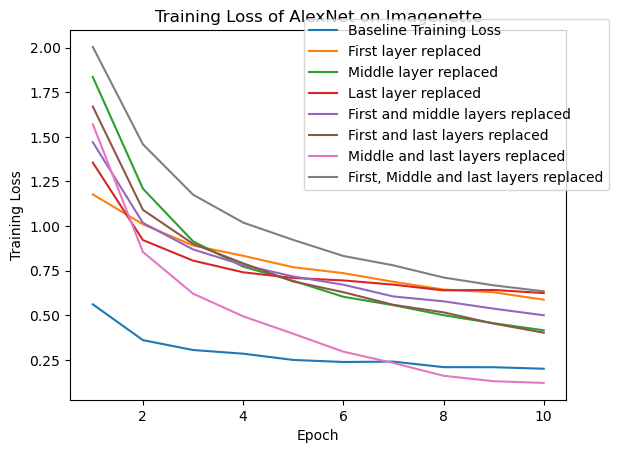

In [89]:
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, train_loss, label="Baseline Training Loss")
plt.plot(epoch, train_loss_firstreplaced, label="First layer replaced")
plt.plot(epoch, train_loss_middlereplaced, label="Middle layer replaced")
plt.plot(epoch, train_loss_replaced, label="Last layer replaced")
plt.plot(epoch, train_loss_firstmiddlereplaced, label="First and middle layers replaced")
plt.plot(epoch, train_loss_firstlastreplaced, label="First and last layers replaced")
plt.plot(epoch, train_loss_middlelastreplaced, label="Middle and last layers replaced")
plt.plot(epoch, train_combined, label="First, Middle and last layers replaced")
plt.title("Training Loss of AlexNet on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()


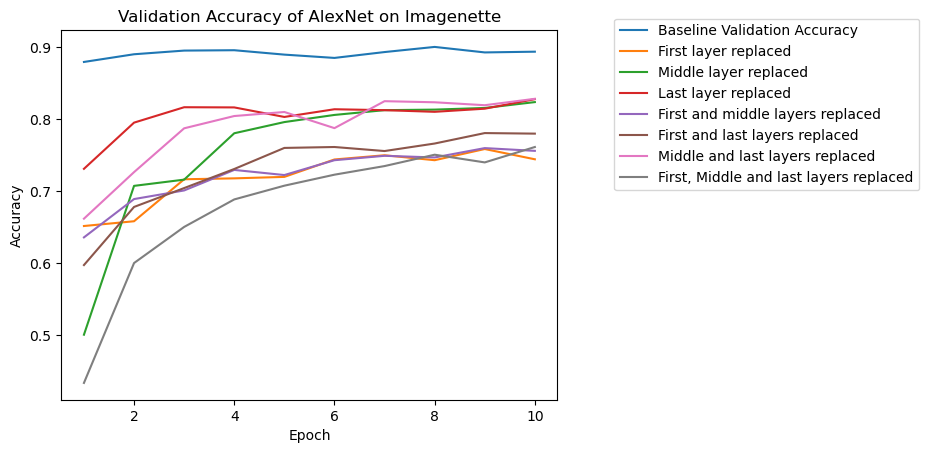

In [90]:
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracy, label="Baseline Validation Accuracy")
plt.plot(epoch, val_accuracy_firstreplaced, label="First layer replaced")
plt.plot(epoch, val_accuracy_middlereplaced, label="Middle layer replaced")
plt.plot(epoch, val_accuracy_replaced, label="Last layer replaced")
plt.plot(epoch, val_accuracy_firstmiddlereplaced, label="First and middle layers replaced")
plt.plot(epoch, val_accuracy_firstlastreplaced, label="First and last layers replaced")
plt.plot(epoch, val_accuracy_middlelastreplaced, label="Middle and last layers replaced")
plt.plot(epoch, val_combined, label="First, Middle and last layers replaced")
plt.title("Validation Accuracy of AlexNet on Imagenette")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
